В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра

In [39]:
import pandas as pd
import numpy as np
import scipy.stats as sp

import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.datasets import make_classification
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

sns.set()
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [40]:
X = pd.read_csv('https://raw.githubusercontent.com/AndroidSaf/Basics_of_ML/main/Homework_1/weather.csv', index_col=0)

In [41]:
y = X.RainTomorrow.replace({'No':0, 'Yes': 1})

In [42]:
del X['RainTomorrow']

## Обработка признаков

In [43]:
counts = np.unique(y.values, return_counts=True)[1]
print('Процент меток, определяющих отсутствие дождя (0): {} %'.format(round(counts[0] / len(y), 4) * 100))
print('Процент меток, определяющих наличие дождя (1): {} %'.format(round(counts[1] / len(y), 4) * 100))

Процент меток, определяющих отсутствие дождя (0): 77.58 %
Процент меток, определяющих наличие дождя (1): 22.42 %


In [44]:
del X['Date']

In [45]:
X.RainToday = X.RainToday.replace({'No': 0, 'Yes': 1})

In [46]:
corr_matrix = X.corr().abs()
upper_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
high_corr_columns = [column for column in upper_corr.columns if any(upper_corr[column] > 0.6)]
X = X.drop(high_corr_columns, axis=1)

In [47]:
X.head()

,Location,MinTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,Humidity9am,Pressure9am,RainToday
0,Albury,13.4,0.6,NaN,NaN,W,44.0,W,WNW,71.0,1007.7,0.0
1,Albury,7.4,0.0,NaN,NaN,WNW,44.0,NNW,WSW,44.0,1010.6,0.0
2,Albury,12.9,0.0,NaN,NaN,WSW,46.0,W,WSW,38.0,1007.6,0.0
3,Albury,9.2,0.0,NaN,NaN,NE,24.0,SE,E,45.0,1017.6,0.0
4,Albury,17.5,1.0,NaN,NaN,W,41.0,ENE,NW,82.0,1010.8,0.0


In [48]:
del X['WindDir9am']
del X['WindDir3pm']

In [49]:
X.MinTemp = X.MinTemp.fillna(X.MinTemp.median())
X.Rainfall = X.Rainfall.fillna(X.Rainfall.median())

In [50]:
numeric_feature_names = X.select_dtypes(exclude='O').columns

for feature in numeric_feature_names:
    median = X[['Location', feature]].groupby(['Location'], 
                                       as_index=False).median().sort_values(by=feature, ascending=False)
    median = median[~median[feature].isna()].values
    for step in median:
        X[feature].where(~X[X['Location'] == step[0]][feature].isin([np.nan]), other=step[1], inplace=True)

In [51]:
wind_by_location = X[['Location', 'WindGustDir', 'RainToday']].groupby(['Location', 'WindGustDir'], 
                                       as_index=False).count().sort_values(by=['Location', 'RainToday'], 
                                                                          ascending=False)
most_common_dir = wind_by_location.groupby(['Location'], 
                                       as_index=False).max().sort_values(by=['Location', 'RainToday'], 
                                                                                           ascending=False)
wind_dir = most_common_dir['WindGustDir'].value_counts().index[0]
X.WindGustDir = X.WindGustDir.fillna(wind_dir)

In [52]:
X.WindGustSpeed = X.WindGustSpeed.fillna(X.WindGustSpeed.median())
X.Pressure9am = X.Pressure9am.fillna(X.Pressure9am.median())

In [53]:
features = ['Evaporation', 'Sunshine']
pivot_table_dir = X[['WindGustDir', 'Evaporation', 'Sunshine']].groupby(['WindGustDir'], 
                                       as_index=False).median().sort_values(by=['Evaporation', 'Sunshine'], ascending=False)
for i in range(pivot_table_dir.shape[0]):
    X.Evaporation.where(~X[X.WindGustDir == pivot_table_dir.loc[i][0]].Evaporation.isin([np.nan]), 
                        other=pivot_table_dir.loc[i][1], inplace=True)
    X.Sunshine.where(~X[X.WindGustDir == pivot_table_dir.loc[i][0]].Sunshine.isin([np.nan]), 
                        other=pivot_table_dir.loc[i][2], inplace=True)

In [54]:
label_encoder = LabelEncoder()
X.Location = label_encoder.fit_transform(X.Location.values)
X.WindGustDir = label_encoder.fit_transform(X.WindGustDir.values)

In [55]:
std = StandardScaler()
X[X.columns[:-1]] = std.fit_transform(X[X.columns[:-1]].values)

In [56]:
X.head()

,Location,MinTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,Humidity9am,Pressure9am,RainToday
0,-1.527004,0.190085,-0.204920,-0.442077,-0.086942,0.990528,0.308922,0.108844,-1.473826,0.0
1,-1.527004,-0.749042,-0.276125,-0.319202,-0.016129,1.196471,0.308922,-1.313293,-1.044051,0.0
2,-1.527004,0.111824,-0.276125,-0.319202,-0.016129,1.402414,0.461063,-1.629323,-1.488646,0.0
3,-1.527004,-0.467304,-0.276125,0.049422,0.585777,-0.862955,-1.212483,-1.260621,-0.006663,0.0
4,-1.527004,0.831821,-0.157450,-0.442077,-0.086942,0.990528,0.080711,0.688233,-1.014411,0.0


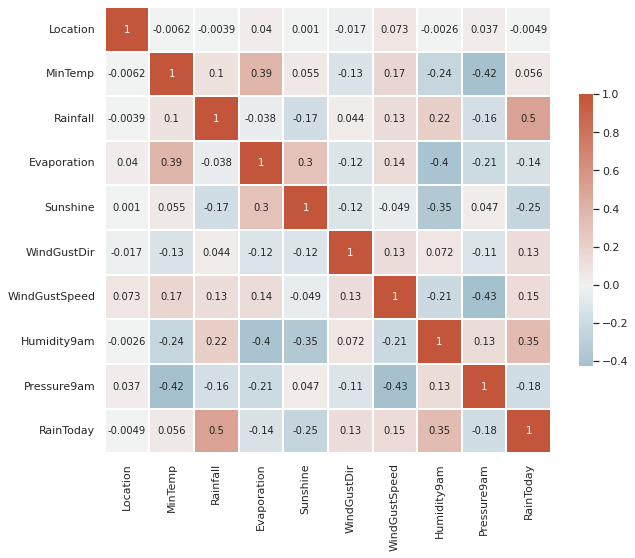

In [57]:
plt.figure(figsize=(10,10))
corr = X.loc[:,:].corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=1, center=0, square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True)

In [58]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = False)

## Логистическая регрессия

In [59]:
%%time
LR = LogisticRegression(C=3, class_weight='balanced', n_jobs=-1)
LR.fit(x_train, y_train)
y_pred = LR.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.91      0.81      0.86     27882
         Yes       0.50      0.70      0.59      7667

    accuracy                           0.79     35549
   macro avg       0.71      0.76      0.72     35549
weighted avg       0.82      0.79      0.80     35549

CPU times: user 147 ms, sys: 108 ms, total: 255 ms
Wall time: 859 ms


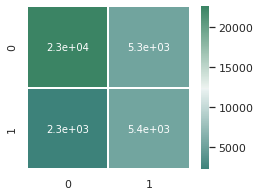

In [60]:
plt.figure(figsize=(4,3))
cmap = sns.diverging_palette(180, 150, as_cmap=True)
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred), index=[0, 1], 
                         columns=[0, 1]), annot=True, linewidths=1, cmap=cmap, square=True)

In [61]:
params = {'C': np.arange(1,11)}
LR = LogisticRegression(class_weight='balanced', n_jobs=-1)
clf_grid = GridSearchCV(LR, params, scoring='recall', refit=True, n_jobs=-1, cv=5, verbose=1)
clf_grid.fit(x_train, y_train)
print(clf_grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.7s finished


{'C': 3}


## K ближайших соседей

In [62]:
%%time
KNN = KNeighborsClassifier(n_neighbors=1, weights='distance', p=x_train.shape[1], n_jobs=-1)
KNN.fit(x_train, y_train)
y_pred = KNN.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.84      0.84      0.84     27882
         Yes       0.42      0.43      0.42      7667

    accuracy                           0.75     35549
   macro avg       0.63      0.63      0.63     35549
weighted avg       0.75      0.75      0.75     35549

CPU times: user 1min 34s, sys: 16.4 ms, total: 1min 34s
Wall time: 49.5 s


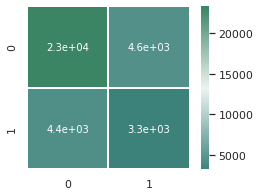

In [63]:
plt.figure(figsize=(4,3))
cmap = sns.diverging_palette(180, 150, as_cmap=True)
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred), index=[0, 1], 
                         columns=[0, 1]), annot=True, linewidths=1, cmap=cmap, square=True)

In [65]:
params = {'n_neighbors': np.arange(1,10)}
LR = KNeighborsClassifier(weights='distance', p=x_train.shape[1], n_jobs=-1)
clf_grid = GridSearchCV(LR, params, scoring='recall', refit=True, n_jobs=-1, cv=5, verbose=1)
clf_grid.fit(x_train, y_train)
print(clf_grid.best_params_)

## Наивный Байес

In [66]:
%%time
NB = GaussianNB()
NB.fit(x_train, y_train)
y_pred = NB.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.86      0.92      0.89     27882
         Yes       0.61      0.45      0.52      7667

    accuracy                           0.82     35549
   macro avg       0.73      0.69      0.70     35549
weighted avg       0.81      0.82      0.81     35549

CPU times: user 103 ms, sys: 2.85 ms, total: 106 ms
Wall time: 108 ms


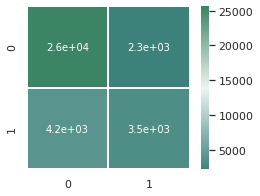

In [67]:
plt.figure(figsize=(4,3))
cmap = sns.diverging_palette(180, 150, as_cmap=True)
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred), index=[0, 1], 
                         columns=[0, 1]), annot=True, linewidths=1, cmap=cmap, square=True)

### Реализация логистической регрессии
__Логистическая регрессия__

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [68]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, 0, 0])

In [69]:
def probability(theta, X):
    result = np.divide(1, 1 + np.exp(-X @ theta.T))
    return result
prob = probability(theta, X)


assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{0, 1\}$

In [70]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    result = np.where(prob > threshold, 1, 0)
    return result

y_pred = binary_class_prediction(theta, X)


assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

__Функционал качества логистической регрессии__

Запишем правдободовие выборки для меток класса $y \in \{+1, -1\}$ 

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Прологарифмируем правдоподобие выборки и перейдем к задаче минимизации:

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Подставим $a(x, \theta)$ в функцинал качества:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$
    

Итоговый оптимизируемый функционал качества (logloss), записанный для меток классов $y \in \{+1, -1\}$ и усредненный по выборке

$$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) \to \operatorname*{min}_{\theta}$$

Реализуем его в функции logloss:

In [71]:
def logloss(theta, X, y):
    result = np.sum(np.log(1 + np.exp(-np.where( y == 1, 1, -1) * (X @ theta.T)))) / y.shape[0]
    return result

In [72]:
assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

__Алгоритм оптимизации функционала качества. Стохастический градиентный спуск__

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся   

Реализуем функцию рассчета градиента функционала качества

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}
    \log \left(
        1 + \exp(- y_i \langle \theta, x_i \rangle)
    \right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}
     \frac {1}{
        1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$

Реализуйте рассчет градиента в матричном виде:

In [73]:
def gradient(theta, X, y):
    y = np.where(y == 1, 1, -1)    
    result = np.sum(-y * X.T * np.exp(-y * (X @ theta.T)) / (1 + np.exp(-y * (X @ theta.T))), axis=1) / y.shape[0]
    return result 

assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

Функция обучения уже реализована

In [74]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(10, 6))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta

### Реализация на произвольно сгенерированных данных

In [75]:
X, y = make_classification(n_samples=2000)

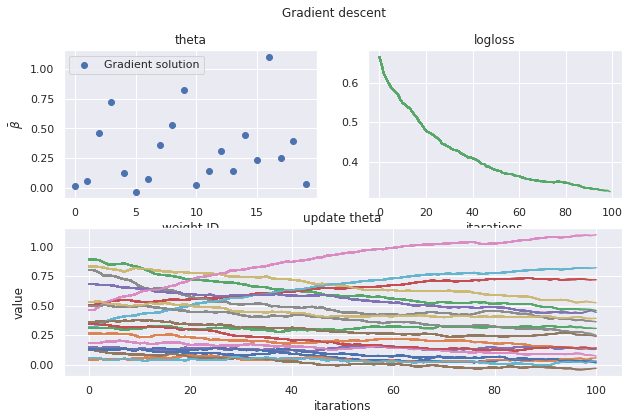

In [76]:
optimal_theta = fit(X, y)

In [77]:
y_pred = binary_class_prediction(optimal_theta, X)
print(classification_report(y, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.89      0.87      0.88      1003
         Yes       0.87      0.89      0.88       997

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



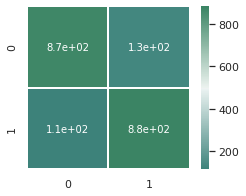

In [78]:
plt.figure(figsize=(4,3))
cmap = sns.diverging_palette(180, 150, as_cmap=True)
sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred), index=[0, 1], 
                         columns=[0, 1]), annot=True, linewidths=1, cmap=cmap, square=True)

### Реализация на данных о погоде

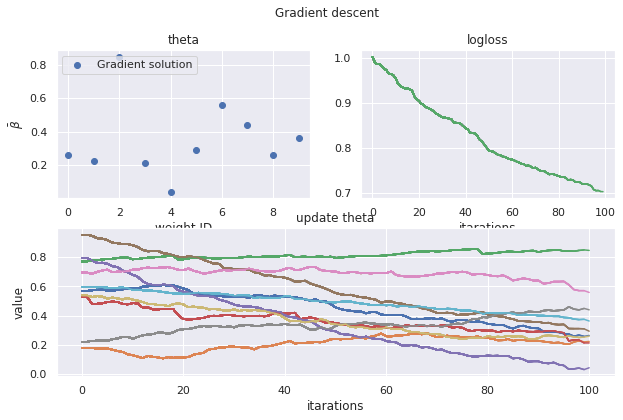

In [79]:
optimal_theta = fit(x_train.values, y_train.values)

In [80]:
y_pred = binary_class_prediction(optimal_theta, x_test.values)
print(classification_report(y_test.values, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.88      0.67      0.76     27882
         Yes       0.36      0.67      0.47      7667

    accuracy                           0.67     35549
   macro avg       0.62      0.67      0.62     35549
weighted avg       0.77      0.67      0.70     35549



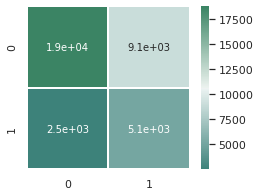

In [81]:
plt.figure(figsize=(4,3))
cmap = sns.diverging_palette(180, 150, as_cmap=True)
sns.heatmap(pd.DataFrame(confusion_matrix(y_test.values, y_pred), index=[0, 1], 
                         columns=[0, 1]), annot=True, linewidths=1, cmap=cmap, square=True)